In [1]:
import numpy      as np
import pandas     as pd
from   pandas     import read_csv

import tensorflow as tf
from   tensorflow import keras

import matplotlib.pyplot as plt 

##### 
### Functions

In [2]:
# Time-Series Generator
def generate_time_series( bSize, nSteps ):  
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, bSize, 1)
    time = np.linspace(0, 1, nSteps)
    series  = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))     #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20))     # + wave 2
    series += 0.1 * (np.random.rand(bSize, nSteps) - 0.5)             # + noise
    return series[..., np.newaxis].astype(np.float32)

# last_time_step_mse
def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

##### 
### Forecasting N Time Steps Ahead

In [7]:
bSize  = 10000   # batch_size
nSteps = 50      #  n_steps 

N = 10
n_neurons =  np.max( [20, 2*N] )

##### 
## Handling Long Sequences
2 Problems:
  - unstable gradients problem.
  - Short-Term Memory

In [87]:
# Handling Unstable Gradients  ( 1 Method Only )
from keras.layers import RNN, Dense, TimeDistributed, SimpleRNNCell, LayerNormalization

class LNSimpleRNNCell(keras.layers.Layer):
    
    def __init__(self, units, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.state_size      = units
        self.output_size     = units
        self.simple_rnn_cell = SimpleRNNCell(units,activation=None)
        self.layer_norm      = LayerNormalization()
        self.activation      = keras.activations.get( activation )
        
    def call(self, inputs, states):
        outputs, new_states  = self.simple_rnn_cell(inputs, states)
        norm_outputs         = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]

model = keras.models.Sequential([
      RNN( LNSimpleRNNCell(64), return_sequences=True, input_shape=[None,1] )
    , RNN( LNSimpleRNNCell(64), return_sequences=True )
    , TimeDistributed( Dense(N) )
    ])

model_long = model

In [ ]:
# Handling Short-Term Memory  ( 4 Methods )
from keras.models import Sequential
from keras.layers import LSTM, RNN, LSTMCell, TimeDistributed, Conv1D, GRU, InputLayer
from keras.optimizers import Adam 

# (1.1)   good   LSTM cells: long-term memory cells 
model = keras.models.Sequential([
      LSTM( 20, return_sequences=True, input_shape=[None,1] )
    , LSTM( 20, return_sequences=True )
    , TimeDistributed( keras.layers.Dense( N ) )
    ])
model_A = model

# (1.2) not-bad  LSTM cells: long-term memory cells 
model = Sequential([
      RNN( LSTMCell(64), return_sequences=True, input_shape=[None,1] )
    , RNN( LSTMCell(64), return_sequences=True )
    , TimeDistributed( Dense(N) )
    ]) 
model_B = model

model = Sequential() 
model.add( LSTM( units=128, return_sequences=True, activation='tanh', input_shape=(X_train.shape[1], 1) ))
model.add( LSTM( units=64, return_sequences=True, activation='tanh'  ))
model.add( TimeDistributed( Dense(64, activation='relu') ))
model.add( TimeDistributed( Dense(N) ))
model_C = model


# (2) Best   1D convolutional layers 
model = Sequential([    
      Conv1D( filters=64, kernel_size=4, strides=2, padding='valid', input_shape=[None,1] )  
    , GRU( 64, return_sequences=True )
    , GRU( 64, return_sequences=True )
    , TimeDistributed( Dense(N) )
    ])
model_D = model

model.compile( loss      = "mse"
             , optimizer = Adam(learning_rate=0.001)   # "adam"
             , metrics   = [last_time_step_mse]

history = model.fit( X_train, Y_train[:, 3::2]
                   , epochs = 20
                   , validation_data = ( X_valid, Y_valid[:, 3::2] ) )


              
# (3) Best   WaveNet 
model = Sequential()
model.add( InputLayer(input_shape=[None,1]) )
for rate in (1, 2, 4, 8) * 2:
    model.add( Conv1D( filters=64, kernel_size=2, padding="causal", activation="relu", dilation_rate=rate ))
model.add( Conv1D( filters=N, kernel_size=1 ))
model_E = model
 
model.compile( loss      = "mse"
             , optimizer = Adam(learning_rate=0.001)   # "adam"
             , metrics   = [last_time_step_mse]
             )

history = model.fit( X_train, Y_train
                   , epochs          =  2
                   , batch_size      =  N  
                   , validation_data = (X_valid, Y_valid)
                   )

In [134]:
# (3) Best   WaveNet 
model = Sequential()
model.add( InputLayer(input_shape=[None,1]) )
for rate in (1, 2, 4, 8) * 2:
    model.add( Conv1D( filters=64, kernel_size=2, padding="causal", activation="relu", dilation_rate=rate ))
model.add( Conv1D( filters=N, kernel_size=1 ))

##### 
## Project 1:   Monthly Armed Robberies in Boston

In [89]:
Project_Name = 'Monthly_Robberies'

df = read_csv('Monthly-Robberies.csv', header=0 )
df.head(5)

,Month,Robberies
0,1966-01,41
1,1966-02,39
2,1966-03,50
3,1966-04,40
4,1966-05,43


In [90]:
S = df.iloc[:,1].values.astype('float32') 
S

array([ 41.,  39.,  50.,  40.,  43.,  38.,  44.,  35.,  39.,  35.,  29.,
        49.,  50.,  59.,  63.,  32.,  39.,  47.,  53.,  60.,  57.,  52.,
        70.,  90.,  74.,  62.,  55.,  84.,  94.,  70., 108., 139., 120.,
        97., 126., 149., 158., 124., 140., 109., 114.,  77., 120., 133.,
       110.,  92.,  97.,  78.,  99., 107., 112.,  90.,  98., 125., 155.,
       190., 236., 189., 174., 178., 136., 161., 171., 149., 184., 155.,
       276., 224., 213., 279., 268., 287., 238., 213., 257., 293., 212.,
       246., 353., 339., 308., 247., 257., 322., 298., 273., 312., 249.,
       286., 279., 309., 401., 309., 328., 353., 354., 327., 324., 285.,
       243., 241., 287., 355., 460., 364., 487., 452., 391., 500., 451.,
       375., 372., 302., 316., 398., 394., 431., 431.], dtype=float32)

In [91]:
def under_under( S ): 
    A = [];
    for i in S:
        A.append([i])
    return A

A = under_under( S.copy() )  

In [92]:
# New_Series
import random as random

def New_Series( A ):
    New = A.copy()
    n = len(New)
    for i in range(n):  
        r = random.uniform(0.9,1.1)
        New[i][0] = New[i][0] * r
    return New   

B = New_Series( A )  
A = under_under( S ) 

In [93]:
N      = 36
nBatch = 20000  

Series = []
for i in range( nBatch+N ):
    A = under_under( S ) 
    Series.append( New_Series( A ) ) 
Series = np.array(Series) 

In [94]:
series = Series.copy()
bSize  = series.shape[0]
nSteps = series.shape[1]-N
n_neurons = max( [20,2*N] )

a, b = int(np.round(.7*bSize,0)), int(np.round(.9*bSize,0))

Y = np.empty(( bSize, nSteps, N ))  
for step_ahead in range( 1, N+1 ):
    Y[ : , : , step_ahead-1 ] = series[ : , step_ahead:step_ahead+nSteps, 0 ]

X_train, Y_train  =  series[  :a, :nSteps ],  Y[  :a ]
X_valid, Y_valid  =  series[ a:b, :nSteps ],  Y[ a:b ]
X_test,  Y_test   =  series[ b: , :nSteps ],  Y[ b:  ] 

In [95]:
model = Sequential() 
model.add( LSTM( units=128, return_sequences=True, activation='tanh', input_shape=(X_train.shape[1], 1) ))
model.add( LSTM( units=64,  return_sequences=True, activation='tanh'  ))
model.add( TimeDistributed( Dense(64, activation='relu') ))
model.add( TimeDistributed( Dense(N) ))
print('Model Defined.')

Model Defined.


##### 

In [148]:
model.compile( loss      = "mse"
             , optimizer =  Adam(learning_rate=0.00005)  #  "adam"
             , metrics   = [last_time_step_mse]
             )

history = model.fit( X_train, Y_train
                   , epochs          =  5
                   , batch_size      =  N  
                   , validation_data = (X_valid, Y_valid)
                   )

Epoch 1/5
390/390 [==============================] - 31s 76ms/step - loss: 218.8296 - last_time_step_mse: 532.2642 - val_loss: 217.8291 - val_last_time_step_mse: 531.5480
Epoch 2/5
390/390 [==============================] - 29s 75ms/step - loss: 217.1006 - last_time_step_mse: 530.2169 - val_loss: 216.8252 - val_last_time_step_mse: 535.0172
Epoch 3/5
390/390 [==============================] - 29s 75ms/step - loss: 215.5267 - last_time_step_mse: 528.0976 - val_loss: 214.9379 - val_last_time_step_mse: 527.0834
Epoch 4/5
390/390 [==============================] - 29s 75ms/step - loss: 213.9948 - last_time_step_mse: 526.3223 - val_loss: 213.2486 - val_last_time_step_mse: 526.2845
Epoch 5/5
390/390 [==============================] - 30s 76ms/step - loss: 212.6843 - last_time_step_mse: 524.6819 - val_loss: 212.6784 - val_last_time_step_mse: 524.2840


In [149]:
Y_pred = model.predict(X_test)   
MSE = np.mean( keras.losses.mean_squared_error( Y_test, Y_pred ) ) 
print('\nRMSE =',np.round(MSE**.5,4))

63/63 [==============================] - 1s 18ms/step

RMSE = 14.6111


##### 

In [150]:
# save weights
version = '02'

model.save_weights( Project_Name + '_' + version
                  , overwrite = True 
                  , save_format = None 
                  , options = None 
                  )

##### 

In [151]:
# load weights
version = '02'
 
model.load_weights( Project_Name + '_' + version 
                  , by_name = False 
                  , skip_mismatch = False 
                  , options = None 
                  )

In [152]:
print('[ true  pred   diff ]')
for i in range(N):
    x1 = df.iloc[:,1].tail(N).values[i]
    x2 = int(  np.round(Y_pred[-1][-1])[i]  )
    dx = np.round( (x2-x1)/x1 , 2 )
    print('[ ', x1,' ', x2,' ',dx, ']')

[ true  pred   diff ]
[  257   265   0.03 ]
[  322   319   -0.01 ]
[  298   306   0.03 ]
[  273   271   -0.01 ]
[  312   308   -0.01 ]
[  249   242   -0.03 ]
[  286   278   -0.03 ]
[  279   268   -0.04 ]
[  309   312   0.01 ]
[  401   395   -0.01 ]
[  309   317   0.03 ]
[  328   318   -0.03 ]
[  353   342   -0.03 ]
[  354   366   0.03 ]
[  327   347   0.06 ]
[  324   322   -0.01 ]
[  285   295   0.04 ]
[  243   239   -0.02 ]
[  241   250   0.04 ]
[  287   290   0.01 ]
[  355   345   -0.03 ]
[  460   465   0.01 ]
[  364   371   0.02 ]
[  487   479   -0.02 ]
[  452   464   0.03 ]
[  391   398   0.02 ]
[  500   506   0.01 ]
[  451   469   0.04 ]
[  375   388   0.03 ]
[  372   370   -0.01 ]
[  302   292   -0.03 ]
[  316   300   -0.05 ]
[  398   389   -0.02 ]
[  394   400   0.02 ]
[  431   415   -0.04 ]
[  431   432   0.0 ]


In [153]:
A = np.array([ under_under(  S  ) ])   # either (the same)
#A = np.array([ under_under( S[N:] ) ])   #   or   (the same)

Y_preds = model.predict( A ) 
Preds = np.round( Y_preds[-1][-1],0 )

1/1 [==============================] - 0s 477ms/step


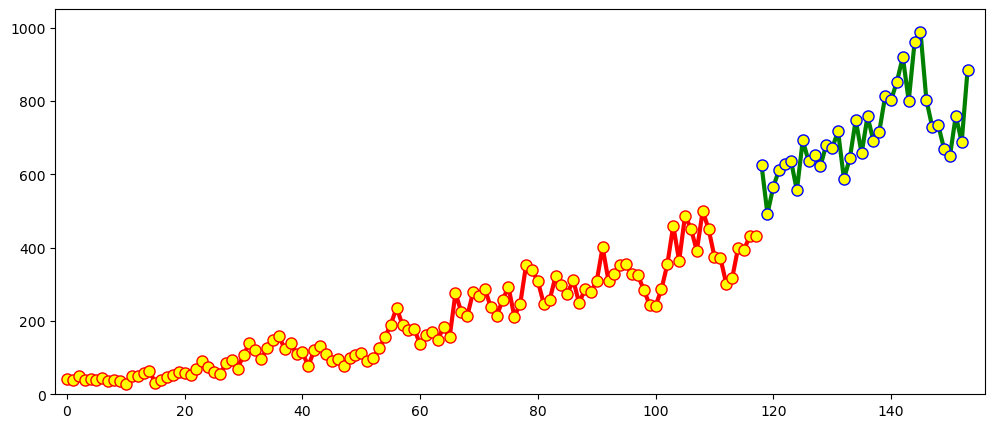

In [154]:
fig, ax = plt.subplots(figsize=(12,5))

ax.plot(  range(len(S)), S
        , lw=3, c='r', ls='-'
        , marker='o', markersize=8
        , mec='red' , mew=1, mfc='yellow')

ax.plot(  np.arange(len(S),len(S)+N), Preds
        , lw=3, c='g', ls='-'
        , marker='o', markersize=8
        , mec='blue', mew=1, mfc='yellow' )
plt.xlim([-2,len(S)+N+2])
plt.ylim([0,1050])

plt.savefig( Project_Name+'_Version_'+version+'_.png', dpi=120 )
plt.show()

##### 

##### 

##### 